In [1]:
from smartsim import Experiment
from smartredis import Client
import skopt
import skopt.plots
import numpy as np

In [2]:
exp = Experiment("Tune_K-Epsilon", launcher="local")

In [24]:
def evaluate_function(values):

    param_names = [
        'Cmu',
        'C1',
        'C2',
        'sigmak',
        'sigmaEps'
    ]

    assert len(param_names) == len(values)

    params = { param_names[i]:[value] for i, value in enumerate(values) }
    print(params)

    rs = exp.create_run_settings(
        "/home/users/shao/dev/OpenFOAM/openfoam/platforms/linux64CrayDPInt32Opt/bin/simpleFoam",
    )
    ens = exp.create_ensemble(
        "evaluation",
        params=params,
        perm_strategy='step',
        run_settings=rs
    )

    for model in ens.models:
        model.attach_generator_files(
            to_configure="pitzDaily",
        )

    exp.generate(ens, overwrite=True)
    exp.start(ens, block=True)

    outputs = []
    true_p = 1.9
    for model in ens.models:
        fname = f'{model.path}/postProcessing/avgInlets/0/surfaceFieldValue.dat'
        data = np.loadtxt(fname, skiprows=5)
        outputs.append( (true_p+data[-1,1])**2 )

    if len(outputs)==1:
        return outputs[0]
    else:
        return outputs

In [25]:
default_values = [0.09, 1.44, 1.92, 1.0, 1.3]
bound_width = 0.5
bounds = [ (val*0.75, val*1.25) for val in default_values ]

In [26]:
res = skopt.gp_minimize(evaluate_function,  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)  # the random seed

{'Cmu': [0.08989486499126922], 'C1': [1.6688436776039302], 'C2': [2.02762741889018], 'sigmak': [1.1356799594312006], 'sigmaEps': [1.534435351395497]}
00:39:54 hotlum-login SmartSim[115200] INFO Working in previously created experiment
00:39:55 hotlum-login SmartSim[115200] WARNING Unused tag label=32 on line(s): [12]
00:39:55 hotlum-login SmartSim[115200] WARNING Unused tag label=32 on line(s): [12]
00:39:55 hotlum-login SmartSim[115200] WARNING Unused tag label=32 on line(s): [12]
00:39:55 hotlum-login SmartSim[115200] WARNING Unused tag label=32 on line(s): [12]
00:39:55 hotlum-login SmartSim[115200] WARNING Unused tag label=32 on line(s): [12]
00:40:00 hotlum-login SmartSim[115200] INFO evaluation_0(175332): Running
00:40:03 hotlum-login SmartSim[115200] INFO evaluation_0(175332): Completed
{'Cmu': [0.0742786634522743], 'C1': [1.2229335064988431], 'C2': [2.2225564166889624], 'sigmak': [0.8294076765922183], 'sigmaEps': [1.0504895879520568]}
00:40:05 hotlum-login SmartSim[115200] INFO

In [27]:
print(res.x)

[0.0749047798222169, 1.163186406820317, 2.264150793991167, 0.8137660660443442, 1.0395326526713358]


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

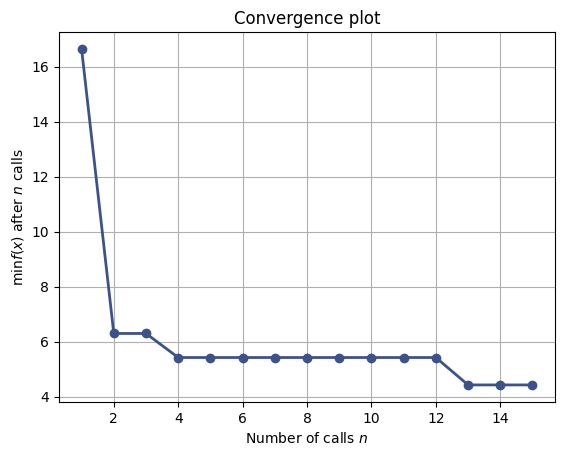

In [28]:
skopt.plots.plot_convergence(res)

In [29]:
param_names = [
        'Cmu',
        'C1',
        'C2',
        'sigmak',
        'sigmaEps'
    ]

In [41]:
print('Parameter     \tDefault\tOptimal')
for i in range(len(param_names)):
    print(f'{param_names[i]}:     \t{default_values[i]}\t{res.x[i]:.4f}')

Parameter     	Default	Optimal
Cmu:     	0.09	0.0749
C1:     	1.44	1.1632
C2:     	1.92	2.2642
sigmak:     	1.0	0.8138
sigmaEps:     	1.3	1.0395
